In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx

from src.models import common_neighbor_community as cnc
from src.features import read_graph as read
from src.features import max_intersect_accuracy as ac

r_seed = 123

%load_ext autoreload
%autoreload 2

This notebook explore the weighted threshold algorithm with a real dataset to see if it can work well on real datasets.

### Read dataset

Since the dataset is actually directed, we make it undirected to enable common neighbors methods. More specifically, since the communities we want to detect is the departments of the nodes. Therefore, one send email to one means these two persons are in contact, so we can assume the directed email can be also identified as an undirected edge.

In [2]:
G = read.createGraph("../data/raw/email_data.txt")
print("Number of nodes:", G.order())
print("Number of edges:", G.size())

Number of nodes: 1005
Number of edges: 16706


In [3]:
actual_com = read.createActualCommunity("../data/raw/email_communities.txt")
print("Number of nodes get community:", len(actual_com))

Number of nodes get community: 1005


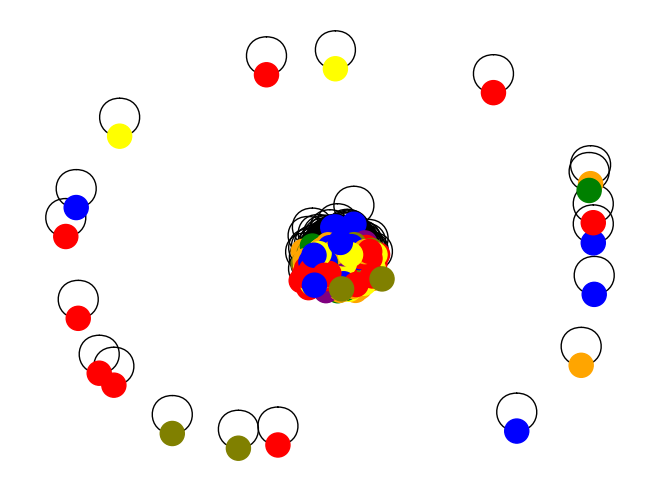

In [4]:

colors = ['red', 'blue','orange','green', 'yellow', 'purple', 'olive']
node_color = [colors[actual_com[i] % 7] for i in G.nodes]
nx.draw(G, node_color=node_color)

As we can see above, since self emails are also included in the dataset, we can see many self loops in the naive visualization of the network. However, as we want to explore the department depending on the fact whether two persons are in contact, we should ignore self loops. Therefore, we remove all self loops from the network. As a result, we removed about 700 edges.

In [5]:
G.remove_edges_from(nx.selfloop_edges(G))
print("Number of nodes:", G.order())
print("Number of edges:", G.size())

Number of nodes: 1005
Number of edges: 16064


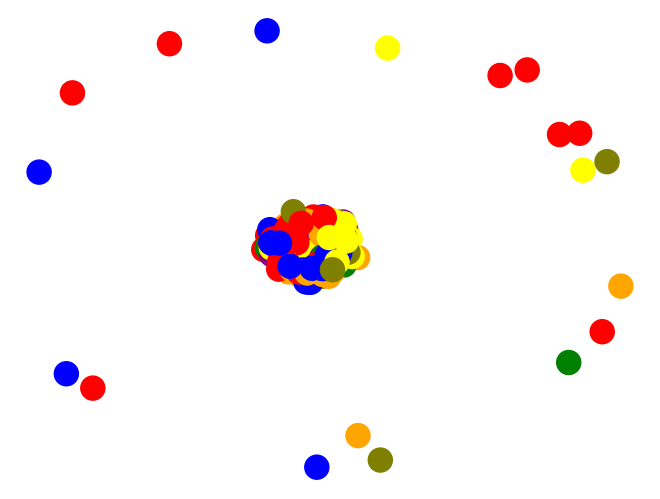

In [6]:
colors = ['red', 'blue','orange','green', 'yellow', 'purple', 'olive']
node_color = [colors[actual_com[i] % 7] for i in G.nodes]
nx.draw(G, node_color=node_color)

Consequently, we got approximately $0.15$ average accuracy. As we know from the dataset, there are $42$ acutal communities, and $0.15 > \frac{1}{42}$. We can say that this also gives am obviously better performance than randomness.

However, we also want to know what is the best performance of this algorithm can do on this dataset.

### Tuning thresholds

Find the best threshold and best accuracy for this dataset.

In [ ]:
def differentThes(lower_thres, higher_thres, interval, CNC):
    avg_accs = []
    ths = []
    max_thres = None
    max_acc = 0.0
    for thres in np.arange(lower_thres, higher_thres, interval):
        CNC.findAllCommunities(thres=thres, weighted=True)
        actual = CNC.getActualCommunities()
        preds = CNC.getPredCommunities()
        
        acc = ac.computeAccuracies(actual, preds)
        
        ths.append(thres)
        avg_accs.append(acc)
        
        if acc > max_acc:
            max_acc = acc
            max_thres = thres
    
    return pd.DataFrame({"accuracy": avg_accs, "threshold": ths}), max_acc, max_thres

def plotThresAcc(df):
    sns.lineplot(data=df, x="threshold", y="accuracy")
    plt.title("Accuracy per Threshold")
    plt.show()
    plt.close()

Max Accuracy: 0.24966366339127521
Max Threshold: 0.28


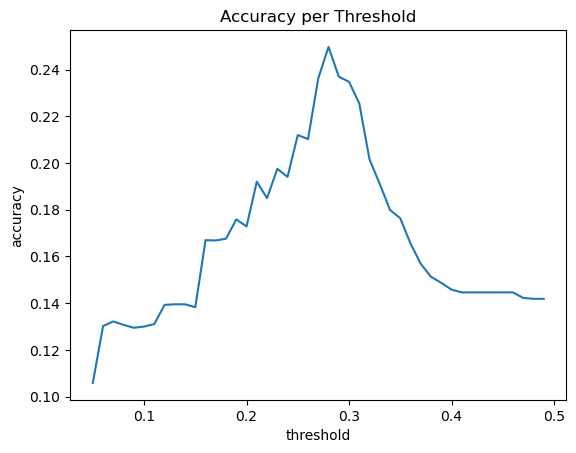

In [ ]:
CNC = cnc.CommonNeighborCommunity(G, actual_com) # reset the graph
df, max_acc, max_thres = differentThes(0.05, 0.5, 0.01, CNC)
print("Max Accuracy:", max_acc)
print("Max Threshold:", max_thres)
plotThresAcc(df)

We eventually got approximately $0.25$ average accuracy, and we can see the performance actually improved.